# Exploratory Data Analysis

* In this study, I will do an exploratory data analysis. I hope that will be useful.

In [53]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings("ignore")

In [39]:
df = pd.read_csv("AttributeDataSet_2.csv")
df.drop(["Dress_ID"], axis=1, inplace=True)
df.head()

,Style,Price,Rating,Size,Season,NeckLine,SleeveLength,Material,FabricType,Decoration,Pattern Type,Recommendation
0,Sexy,Low,4.6,M,Summer,o-neck,sleevless,NaN,chiffon,ruffles,animal,1
1,Casual,Low,0.0,L,Summer,o-neck,Petal,microfiber,NaN,ruffles,animal,0
2,vintage,High,0.0,L,Automn,o-neck,full,polyster,NaN,NaN,print,0
3,Brief,Average,4.6,L,Spring,o-neck,full,silk,chiffon,embroidary,print,1
4,cute,Low,4.5,M,Summer,o-neck,butterfly,chiffonfabric,chiffon,bow,dot,0


In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,479.0,3.489353,2.028941,0.0,2.0,4.6,4.8,5.0
Recommendation,479.0,0.427975,0.495302,0.0,0.0,0.0,1.0,1.0


In [40]:
def eksik_deger_tablosu(df): 
    eksik_deger = df.isnull().sum()
    eksik_deger_yuzde = 100 * df.isnull().sum()/len(df)
    eksik_deger_tablo = pd.concat([eksik_deger, eksik_deger_yuzde], axis=1)
    eksik_deger_tablo_son = eksik_deger_tablo.rename(columns = {0: "Eksik Değerler", 1: "% Değeri"})
    return eksik_deger_tablo_son

print("\n" "Data Shape:", df.shape, "\n")
eksik_deger_tablosu(df)


Data Shape: (479, 12) 



,Eksik Değerler,% Değeri
Style,0,0.000000
Price,2,0.417537
Rating,0,0.000000
Size,0,0.000000
Season,2,0.417537
NeckLine,3,0.626305
SleeveLength,2,0.417537
Material,119,24.843424
FabricType,256,53.444676
Decoration,224,46.764092


In [41]:
def NaNChecker(data, collist, tol):
    drop_list = []
    for col in collist:
        if data[col].isnull().sum() / len(data) > tol:
            drop_list.append(col)
        else:
            continue
    return drop_list

print("Doluluk oranı %20'nin altında olanlar:", NaNChecker(df, df.columns, 0.10))

Doluluk oranı %20'nin altında olanlar: ['Material', 'FabricType', 'Decoration', 'Pattern Type']


In [42]:
df.drop(NaNChecker(df, df.columns, 0.10), axis = 1, inplace = True)
df.reset_index(drop = True, inplace = True)
df.head()

,Style,Price,Rating,Size,Season,NeckLine,SleeveLength,Recommendation
0,Sexy,Low,4.6,M,Summer,o-neck,sleevless,1
1,Casual,Low,0.0,L,Summer,o-neck,Petal,0
2,vintage,High,0.0,L,Automn,o-neck,full,0
3,Brief,Average,4.6,L,Spring,o-neck,full,1
4,cute,Low,4.5,M,Summer,o-neck,butterfly,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Style           479 non-null    object 
 1   Price           477 non-null    object 
 2   Rating          479 non-null    float64
 3   Size            479 non-null    object 
 4   Season          477 non-null    object 
 5   NeckLine        476 non-null    object 
 6   SleeveLength    477 non-null    object 
 7   Recommendation  479 non-null    int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 30.1+ KB


# Fixing the Rows and Columns

In [16]:
pd.unique(df["Size"])

array(['M', 'L', 'XL', 'free', 'S', 'small', 's'], dtype=object)

In [17]:
df["Size"].replace(["M", "L", "XL", "free", "S", "small", "s"], 
                   ["Medium", "Large", "Extra Large", "Free", "Small", "Small", "Small"], inplace = True)

pd.unique(df["Size"])

array(['Medium', 'Large', 'Extra Large', 'Free', 'Small'], dtype=object)

In [31]:
df_size = pd.DataFrame([df["Size"].value_counts(), df["Size"].value_counts(normalize = True)*100]).T
df_size.columns = ["Unique", "%Unique"]
df_size

,Unique,%Unique
Medium,171.0,35.699374
Free,165.0,34.446764
Large,93.0,19.415449
Small,36.0,7.515658
Extra Large,14.0,2.922756


In [49]:
col_data = []

for col in df.columns:
    if type(df[col].loc[0]) == str:
        col_data.append((col, "categorical"))
    else:
        col_data.append((col, "not-categorical"))
        
col_data = pd.DataFrame(col_data, columns = ["Col", "Category"])

for col in col_data[col_data.Category == "categorical"].Col.values:
    df[col] = df[col].astype("category")
    
col_data

,Col,Category
0,Style,categorical
1,Price,categorical
2,Rating,not-categorical
3,Size,categorical
4,Season,categorical
5,NeckLine,categorical
6,SleeveLength,categorical
7,Recommendation,not-categorical


In [50]:
corr_data = df.copy()

for col in col_data[col_data["Category"] == "categorical"]["Col"].values:
    corr_data[col] = corr_data[col].cat.codes   
    
corr = corr_data.corr()
corr.style.background_gradient(cmap="coolwarm")

,Style,Price,Rating,Size,Season,NeckLine,SleeveLength,Recommendation
Style,1.000000,0.048050,0.003926,-0.132881,-0.006834,0.039748,0.115192,0.079594
Price,0.048050,1.000000,-0.006841,0.146728,0.012425,-0.042214,0.002345,0.159117
Rating,0.003926,-0.006841,1.000000,-0.084160,0.017914,-0.081171,0.080287,0.047845
Size,-0.132881,0.146728,-0.084160,1.000000,0.035202,0.086534,-0.032179,0.027692
Season,-0.006834,0.012425,0.017914,0.035202,1.000000,0.025610,-0.027146,0.002916
NeckLine,0.039748,-0.042214,-0.081171,0.086534,0.025610,1.000000,0.040495,-0.021505
SleeveLength,0.115192,0.002345,0.080287,-0.032179,-0.027146,0.040495,1.000000,-0.006715
Recommendation,0.079594,0.159117,0.047845,0.027692,0.002916,-0.021505,-0.006715,1.000000


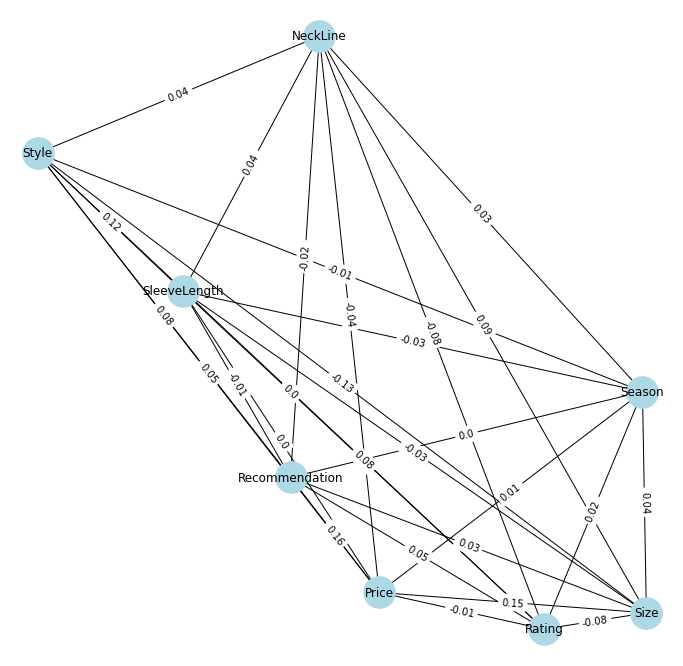

In [54]:
cor_matrix = np.asmatrix(corr)

G = nx.from_numpy_matrix(cor_matrix)
G = nx.relabel_nodes(G,lambda x: corr.columns[x])

def drawGraph(G, size=12):
    fig, ax = plt.subplots()
    fig.set_size_inches(size,size)
    
    pos_fr = nx.fruchterman_reingold_layout(G)
    edges = G.edges()

    weights = [G[u][v]["weight"] for u,v in edges]
    labels = {e: round(G[e[0]][e[1]]["weight"], 2) for e in edges}
    weights2 = [w for w in weights]

    nx.draw(G, pos=pos_fr, node_size=1000, node_color="lightblue", with_labels=True)
    nx.draw_networkx_edge_labels(G, pos=pos_fr, edge_labels=labels, ax=ax)
    
drawGraph(G)

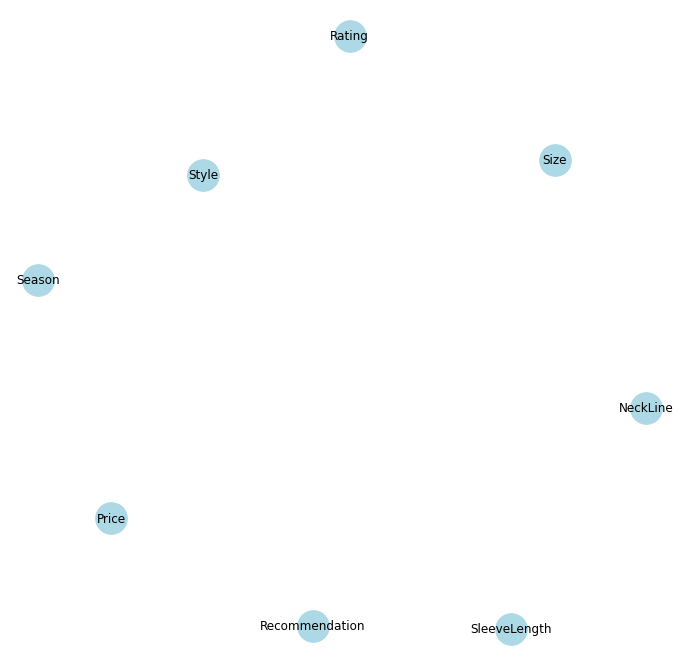

In [55]:
G.remove_edges_from([(u,v) for u,v,e in G.edges(data=True) if e["weight"] < 0.85])
drawGraph(G)